# Estimate a probability with the flood model

In this example, we estimate the probability that the ouput of a function exceeds a given threshold with the FORM method. We consider the flooding model.

## Introduction

The following figure presents the dyke that protects industrial facilities. When the river height exceeds the one of the dyke, flooding occurs. The model is based on a crude simplification of the 1D hydrodynamical equations of Saint-Venant under the assumptions of uniform and constant flowrate and large rectangular sections.

<img src="river_section_adjusted_light.png" width="400" />

Four independent random variables are considered:

 - Q (Flow rate) [m^3 s^-1]
 - Ks (Strickler) [m^1/3 s^-1]
 - Zv (downstream height) # [m]
 - Zm (upstream height) # [m]

When the Strickler coefficient increases, the riverbed generates less friction. 

We consider the four following parameters:

* the height of the dyke : Hd = 3 [m],
* the level of the banks of the river Zb = 55.5 [m],
* the length of the river L = 5000 [m],
* the width of the river B = 300 [m].

The height of the dyke is:

$$
Z_d = Z_b + H_d
$$

The slope of the river is assumed to be close to zero, which implies:

$$
\alpha = \frac{Z_m - Z_v}{L},
$$

if $Z_m \geq Z_v$. 

The height of the water level is:

$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$

for any $K_s, Q>0$.

Therefore, the height of the flood is:

$$
Z_c = H + Z_v
$$

The water level is greater than the height of the dyke (i.e. there is a flood) if:

$$
S = Z_c - Z_d
$$

is greater than zero.

If we substitute the parameters into the equation, we get:

$$
S = \left(\frac{Q}{300 Ks \sqrt{(Zm-Zv)/5000}}\right)^{3/5} +Zv-55.5-3.
$$

We assume that the four inputs have the following distributions:

 - Q ~ Gumbel(mode=1013, scale=558), Q > 0
 - Ks ~ Normal(mu=30.0, sigma=7.5), Ks > 0
 - Zv ~ Uniform(a=49, b=51)
 - Zm ~ Uniform(a=54, b=56)

Moreover, we assume that the input random variables are independent.

It is considered that failure occurs when the difference between the dike height and the water level is positive. In other words, we want to estimate the probability:

$$
P_f = P(S>0).
$$


## References

* Iooss B, Lemaître P (2015) A review on global sensitivity analysis methods. In: Meloni C., Dellino G. (eds) Uncertainty management in Simulation-Optimization of Complex Systems: Algorithmsand Applications, Springer
* Baudin M., Dutfoy A., Iooss B., Popelin AL. (2015) OpenTURNS: An Industrial Software for Uncertainty Quantification in Simulation. In: Ghanem R., Higdon D., Owhadi H. (eds) Handbook of Uncertainty Quantification. Springer

## Define the model

In [1]:
from __future__ import print_function
import openturns as ot

In [2]:
# Create the marginal distributions of the parameters
dist_Q = ot.TruncatedDistribution(ot.Gumbel(558., 1013.), 0, ot.TruncatedDistribution.LOWER)
dist_Ks = ot.TruncatedDistribution(ot.Normal(30.0, 7.5), 0, ot.TruncatedDistribution.LOWER)
dist_Zv = ot.Uniform(49.0, 51.0)
dist_Zm = ot.Uniform(54.0, 56.0)
marginals = [dist_Q, dist_Ks, dist_Zv, dist_Zm]

In [3]:
# Create the Copula
RS = ot.CorrelationMatrix(4)
#RS[2, 3] = -0.2
# Evaluate the correlation matrix of the Normal copula from RS
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
# Create the Normal copula parametrized by R
copula = ot.NormalCopula(R) 

In [4]:
# Create the joint probability distribution
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(['Q', 'Ks', 'Zv', 'Zm'])

In [5]:
# create the model
model = ot.SymbolicFunction(['Q', 'Ks', 'Zv', 'Zm'],
                            ['(Q/(Ks*300.*sqrt((Zm-Zv)/5000)))^(3.0/5.0)+Zv-55.5-3.'])

## Define the event

Then we create the event we want to estimate the probability.

In [6]:
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(model, vect)
event = ot.ThresholdEvent(G, ot.Greater(), 0.0)
event.setName('overflow')

## Estimate the probability with FORM

In [7]:
# Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(1000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

In [8]:
# Run FORM
startingPoint = distribution.getMean()
algo = ot.FORM(optimAlgo, event, startingPoint)
algo.run()
result = algo.getResult()
standardSpaceDesignPoint = result.getStandardSpaceDesignPoint()

In [9]:
# retrieve results
result = algo.getResult()
probability = result.getEventProbability()
print('Pf=', probability)

Pf= 0.0005340887806479517


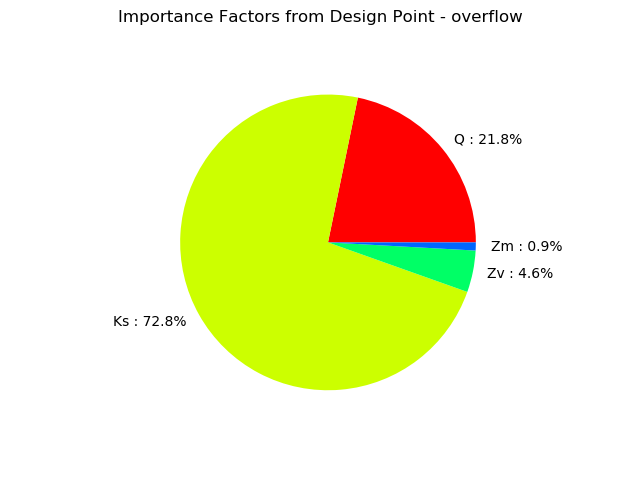

In [10]:
# Importance factors
result.drawImportanceFactors()